In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

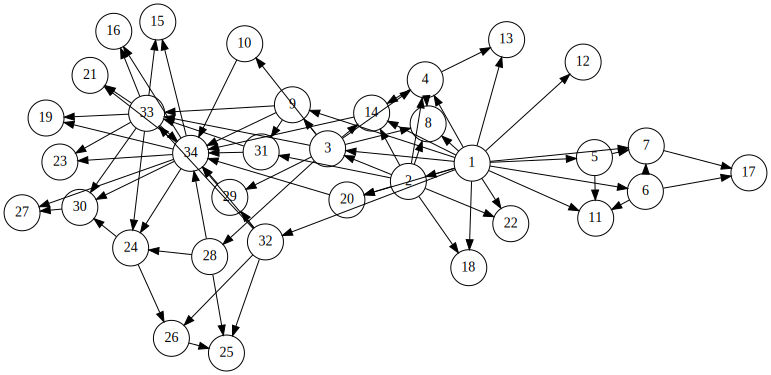

In [37]:
from timeit import repeat
from pygraphblas import *
from pygraphblas.gviz import *

karate = list(Matrix.ssget('Newman/karate'))[-1][1]

# get one-based lables
labels = karate.cast(INT64).apply(INT64.POSITIONI1).reduce_vector(INT64.ANY_MONOID)
g = draw_graph(karate, label_vector=labels, show_weight=False, label_width=5, graph_attr=dict(layout='sfdp'))
g

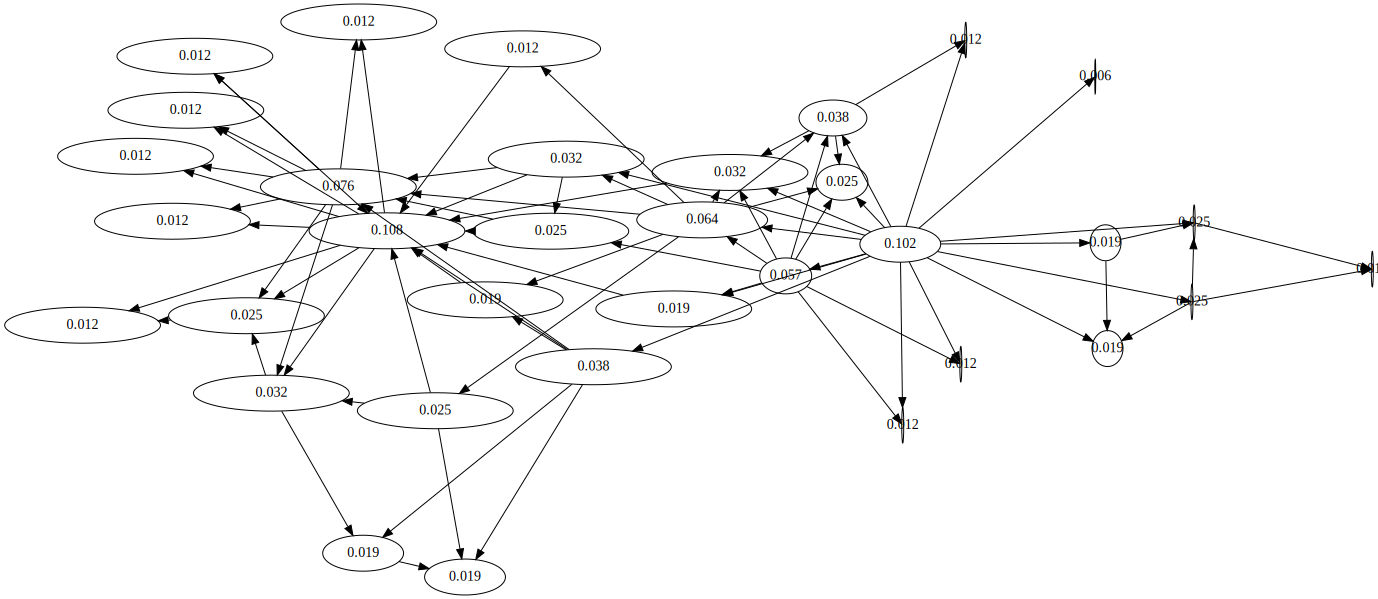

In [39]:
def DC(A):
    v = Vector.dense(A.type, A.nrows, 1.0)
    with FP64.PLUS_PAIR:
        return (A @ v) / A.nvals

dc = DC(karate)
draw_graph(karate, label_vector=dc, size_vector=dc, size_scale=80, log_scale=True, show_weight=False, label_width=5, graph_attr=dict(layout='sfdp'))

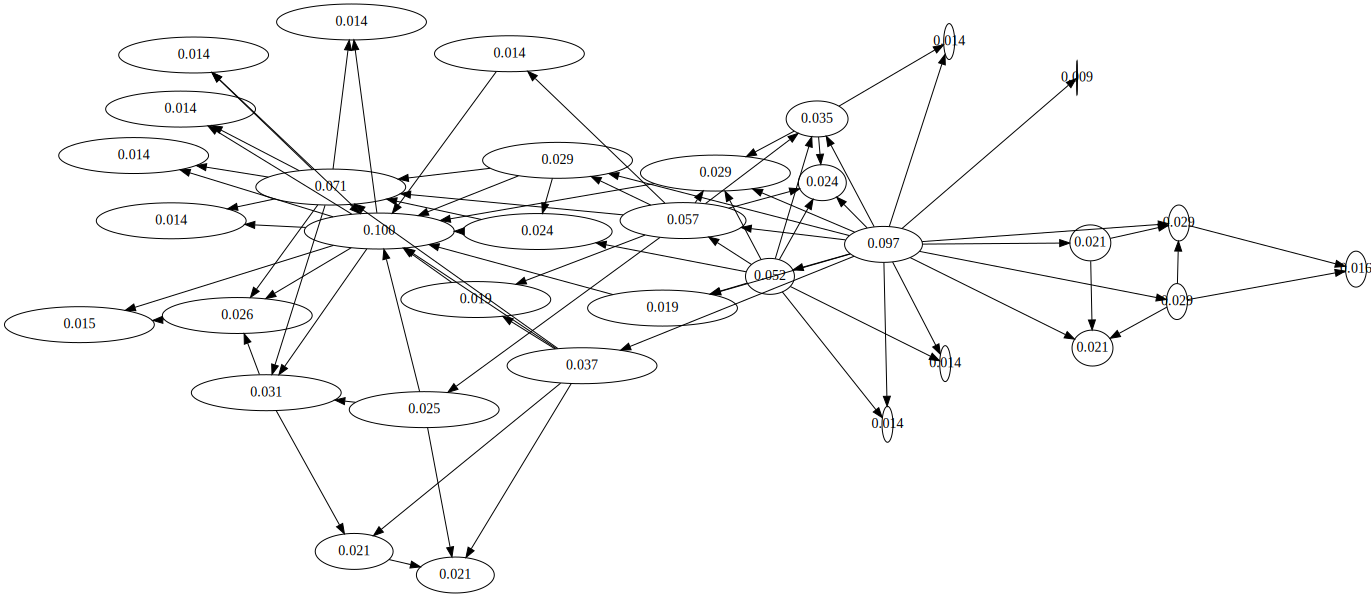

In [41]:
def PR(A, damping, itermax):
    n = A.nrows
    r = Vector.sparse(FP32, n)
    t = Vector.sparse(FP32, n)
    d = A.reduce_vector()
    d.assign_scalar(damping, accum=FP32.DIV)
    r[:] = 1.0 / n
    teleport = (1 - damping) / n
    tol = 1e-4
    rdiff = 1.0
    for i in range(itermax):
        # swap t and r
        temp = t ; t = r ; r = temp
        w = t / d
        r[:] = teleport
        A.mxv(w, out=r, accum=FP32.PLUS, semiring=FP32.PLUS_SECOND,
              desc=descriptor.T0)
        t -= r
        t.apply(FP32.ABS, out=t)
        rdiff = t.reduce_float()
        if rdiff <= tol:
            break
    return r

pr = PR(karate, 0.85, 100)
draw_graph(karate, label_vector=pr, size_vector=pr, size_scale=80, log_scale=True, show_weight=False, label_width=5, graph_attr=dict(layout='sfdp'))

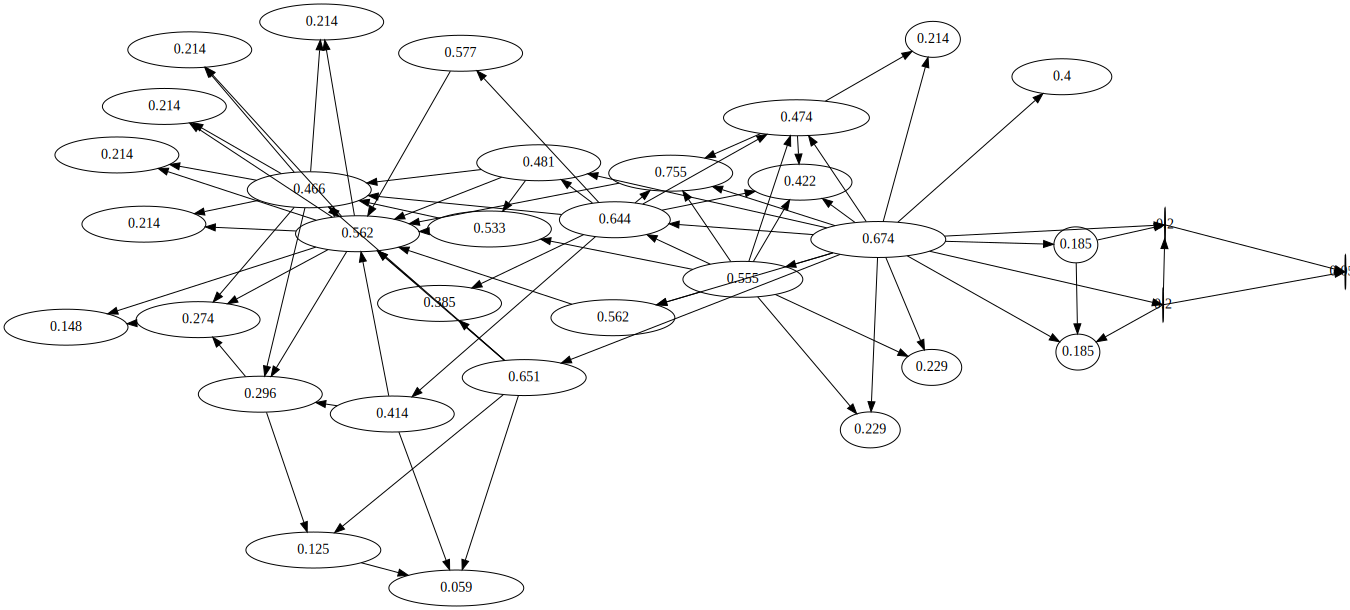

In [44]:
def TC(A):
    T = A.mxm(A, mask=A)
    y = T.reduce_vector()
    k = y.reduce_float()
    return (1/k) * (3 * (A @ y) - 2 * T.mxv(y, semiring=FP64.PLUS_SECOND) + y)

tc = TC(karate)
draw_graph(karate, label_vector=tc, size_vector=tc, size_scale=10, log_scale=True, show_weight=False, label_width=5, graph_attr=dict(layout='sfdp'))

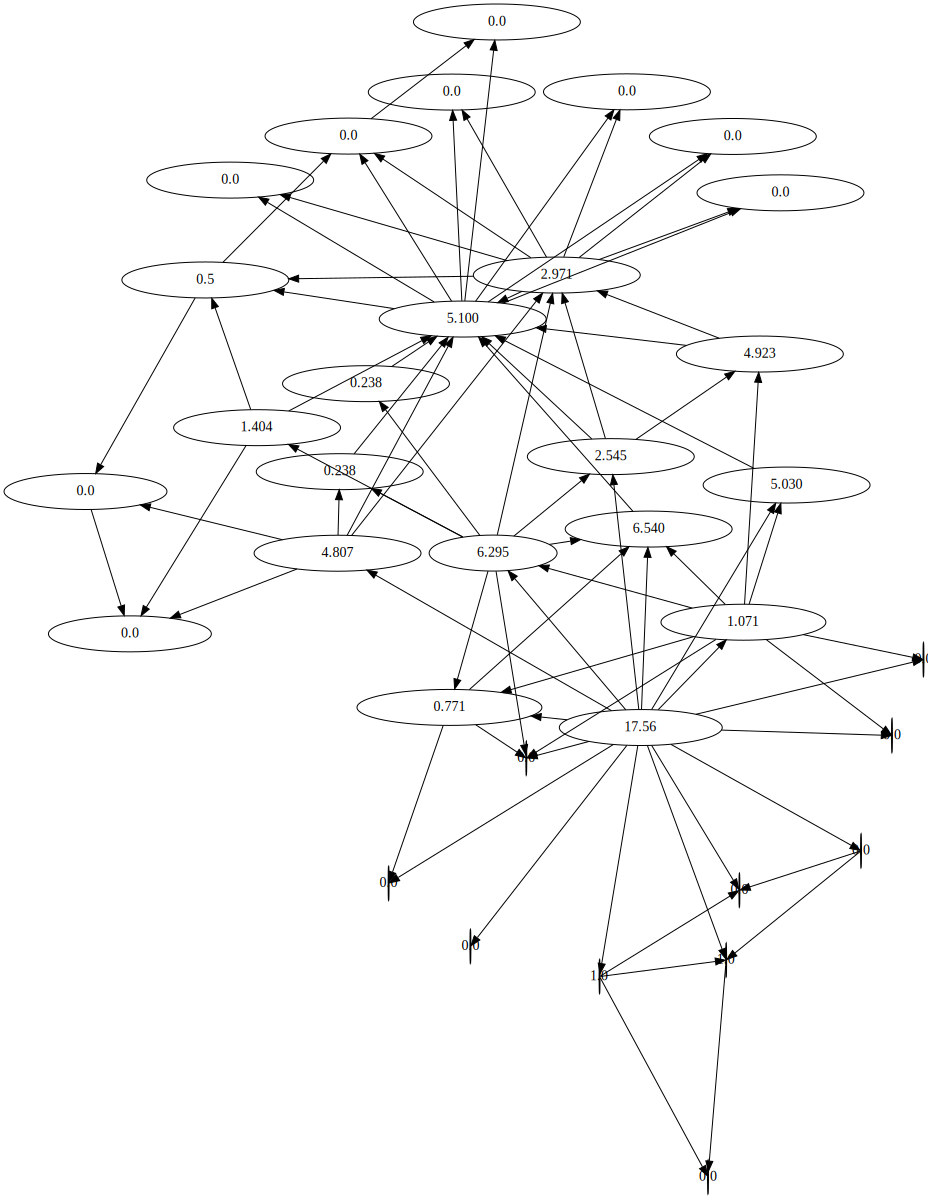

In [6]:
def BC(A, sources):
    AT = A.T
    n = A.nrows
    ns = len(sources)
    paths      = Matrix.dense (FP32, ns, n, 0)
    frontier   = Matrix.sparse(FP32, ns, n)
    S = []

    for i, s in enumerate(sources):
        paths[   i, sources[i]] = 1
        frontier[i, sources[i]] = 1

    frontier.mxm(
        A,
        out=frontier,
        mask=paths,
        semiring=FP32.PLUS_FIRST,
        desc=descriptor.RC)

    for depth in range(n):
        if frontier.nvals == 0:
            break
        s = Matrix.sparse(BOOL, ns, n)
        frontier.apply(BOOL.ONE, out=s)
        S.append(s)
        paths.assign_matrix(frontier, accum=FP32.PLUS)
        frontier.mxm(A,
            out=frontier,
            mask=paths,
            semiring=FP32.PLUS_FIRST,
            desc=descriptor.RC)

    bc = Matrix.dense(FP32, ns, n, 1)
    W = Matrix.sparse(FP32, ns, n)

    for i in range(depth - 1, 0, -1):
        bc.emult(paths, FP32.DIV,
                 out=W,
                 mask=S[i],
                 desc=descriptor.R)
        W.mxm(AT, out=W,
              mask=S[i-1],
              semiring=FP32.PLUS_FIRST,
              desc=descriptor.R)
        W.emult(paths, FP32.TIMES,
                out=bc,
                accum=FP32.PLUS)

    centrality = Vector.dense (FP32, n, -ns)
    bc.reduce_vector(accum=FP32.PLUS,
                     out=centrality,
                     desc=descriptor.T0)
    return centrality

bc = BC(karate, [1, 33])
draw_graph(karate, label_vector=bc, size_vector=bc, size_scale=2, log_scale=True, show_weight=False, label_width=5, graph_attr=dict(layout='neato'))

In [21]:
from collections import defaultdict

graphs = [
#    ('Newman/karate', -1),
#    ('SNAP/wiki-Vote', -1),
    ('SNAP/com-Amazon', 0),
    ('SNAP/com-Youtube', -1),
    ('SNAP/as-Skitter', -1),
    # 'SNAP/com-LiveJournal',
    # 'SNAP/com-Orkut',
    # 'SNAP/com-Friendster'
]

algorithms = [(DC, ()), 
              (TC, ()),
              (PR, (0.85, 100)),
              (BC, ([0, 33],)),
             ]

results = defaultdict(dict)
R = 3
N = 1
for name, offset in graphs:
    print(f'Loading {name}')
    G = list(Matrix.ssget(name))[offset][1]
    G = G + G.T    
    for f, args in algorithms:
        fname = f.__name__
        print(f'Running {fname} {args} on {name} {R} times')
        result = repeat(f'{fname}(G, *args)', repeat=R, number=N, globals=locals())
        avg = sum(result) / len(result)
        print(f'{fname} on {name} took ', avg, f'average for {R} runs')
        results[name][fname] = avg

results

Loading SNAP/com-Amazon
Running DC () on SNAP/com-Amazon 3 times
DC on SNAP/com-Amazon took  0.005992659668360527 average for 3 runs
Running TC () on SNAP/com-Amazon 3 times
TC on SNAP/com-Amazon took  0.29701941333284293 average for 3 runs
Running PR (0.85, 100) on SNAP/com-Amazon 3 times
PR on SNAP/com-Amazon took  0.43452936700487044 average for 3 runs
Running BC ([0, 33],) on SNAP/com-Amazon 3 times
BC on SNAP/com-Amazon took  0.26048227499510784 average for 3 runs
Loading SNAP/com-Youtube
Running DC () on SNAP/com-Youtube 3 times
DC on SNAP/com-Youtube took  0.006853908664197661 average for 3 runs
Running TC () on SNAP/com-Youtube 3 times
TC on SNAP/com-Youtube took  3.5555741796658062 average for 3 runs
Running PR (0.85, 100) on SNAP/com-Youtube 3 times
PR on SNAP/com-Youtube took  0.8339977203383265 average for 3 runs
Running BC ([0, 33],) on SNAP/com-Youtube 3 times
BC on SNAP/com-Youtube took  0.34882044266851153 average for 3 runs
Loading SNAP/as-Skitter
Running DC () on SNAP

defaultdict(dict,
            {'SNAP/com-Amazon': {'DC': 0.005992659668360527,
              'TC': 0.29701941333284293,
              'PR': 0.43452936700487044,
              'BC': 0.26048227499510784},
             'SNAP/com-Youtube': {'DC': 0.006853908664197661,
              'TC': 3.5555741796658062,
              'PR': 0.8339977203383265,
              'BC': 0.34882044266851153},
             'SNAP/as-Skitter': {'DC': 0.011394005991557302,
              'TC': 10.98794753732606,
              'PR': 2.6640761960006785,
              'BC': 0.9271689146650411}})

SNAP/com-Amazon-DC 0.005992659668360527
SNAP/com-Amazon-TC 0.29701941333284293
SNAP/com-Amazon-PR 0.43452936700487044
SNAP/com-Amazon-BC 0.26048227499510784
SNAP/com-Youtube-DC 0.006853908664197661
SNAP/com-Youtube-TC 3.5555741796658062
SNAP/com-Youtube-PR 0.8339977203383265
SNAP/com-Youtube-BC 0.34882044266851153
SNAP/as-Skitter-DC 0.011394005991557302
SNAP/as-Skitter-TC 10.98794753732606
SNAP/as-Skitter-PR 2.6640761960006785
SNAP/as-Skitter-BC 0.9271689146650411


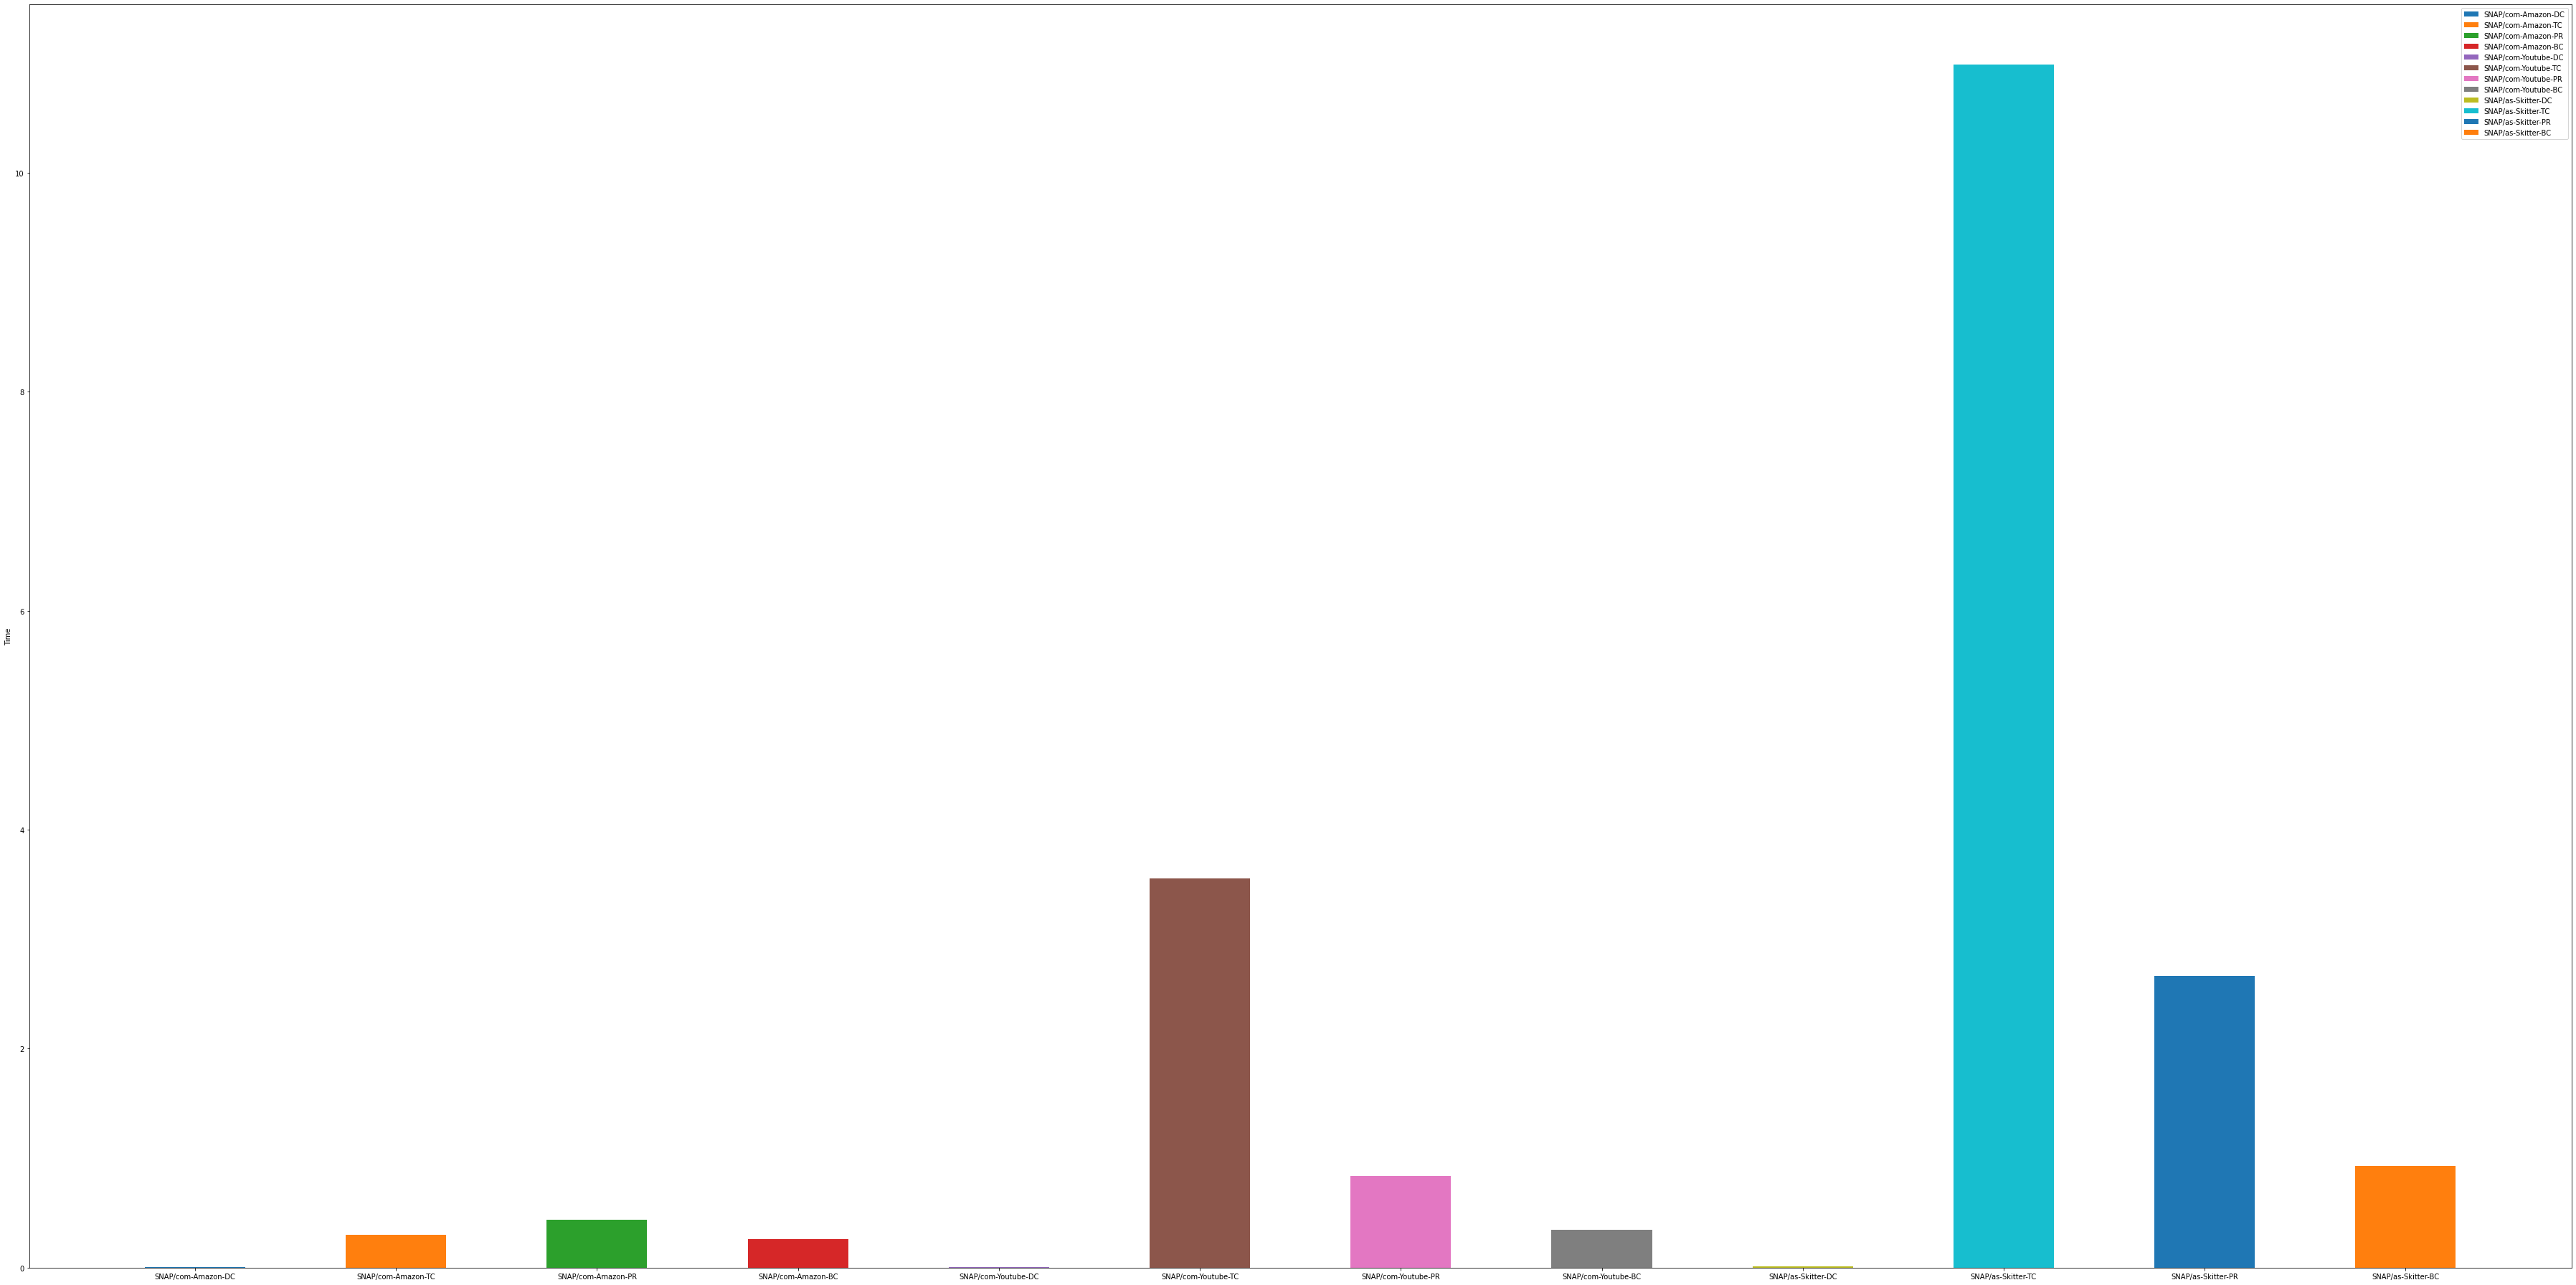

In [26]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = []

width = 0.5  # the width of the bars
fig, ax = plt.subplots()
#plt.rcParams['figure.figsize'] = [50, 25]

for name, runs in results.items():
    for a, times in runs.items():
        label = name + '-' + a
        print(label, times)
        ax.bar(label, times, width, label=label)
        labels.append(label)

ax.set_ylabel('Time')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()
